In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import time
import random
import multiprocessing

In [2]:
class Diffuse:  # 默认网络结构为节点数量为10000，边为60000的单向随机网络
    def __init__(self, p, q, G=nx.gnm_random_graph(10000, 30000),  num_runs=30):
        self.G = G
        self.p, self.q = p, q
        self.num_runs = num_runs
        
    def decision(self, i):  # 线性决策规则
        dose = sum([self.G.node[k]['state'] for k in self.G.node[i]['neigh']])
        prob = self.p + self.q * dose
        return True if random.random() <= prob else False
        
    def single_diffuse(self):  # 单次扩散
        for i in self.G:
            self.G.node[i]['neigh'] = list(self.G.neighbors(i))
            self.G.node[i]['state'] = False
            
        non_adopt_set = [i for i in self.G if self.G.node[i]['state'] == False]
        num_of_adopt = []
        j = 1
        while j <= self.num_runs:                            
            x = 0
            random.shuffle(non_adopt_set)
            for i in non_adopt_set:                   
                if self.decision(i):
                    self.G.node[i]['state'] = True
                    non_adopt_set.remove(i)
                    x += 1
            num_of_adopt.append(x)
            j += 1
            
        return num_of_adopt
    
    def repete_diffuse(self, repetes=10):  #多次扩散      
        return [self.single_diffuse() for  i in xrange(repetes)]

In [3]:
class Diffuse_c(Diffuse):
    def decision(self, i):  # gmm决策规则
        dose = sum([self.G.node[k]['state'] for k in self.G.node[i]['neigh']])
        prob = self.p + self.q * dose
        return True if random.random() <= min(prob, 1) else False

### 1. $\mathrm{min}(p + q\cdot a(t))$ 和 $p + q\cdot a(t)$是等效的

In [31]:
pq_cont = [(0.005, 0.1), (0.01, 0.05), (0.005, 0.1), (0.01, 0.05)]
d_cont = []
for p, q in pq_cont:
    t1 = time.clock()
    diff1 = Diffuse(p, q, num_runs=40)
    diff2 = Diffuse_c(p, q, num_runs=40)
    x = diff1.repete_diffuse(repetes=20)
    y = diff2.repete_diffuse(repetes=20)
    d_cont.append([np.mean(x, axis=0), np.mean(y, axis=0)])
    print '耗时: %.2f 秒'%(time.clock() - t1)

耗时: 27.63 秒
耗时: 30.37 秒
耗时: 26.06 秒
耗时: 28.43 秒


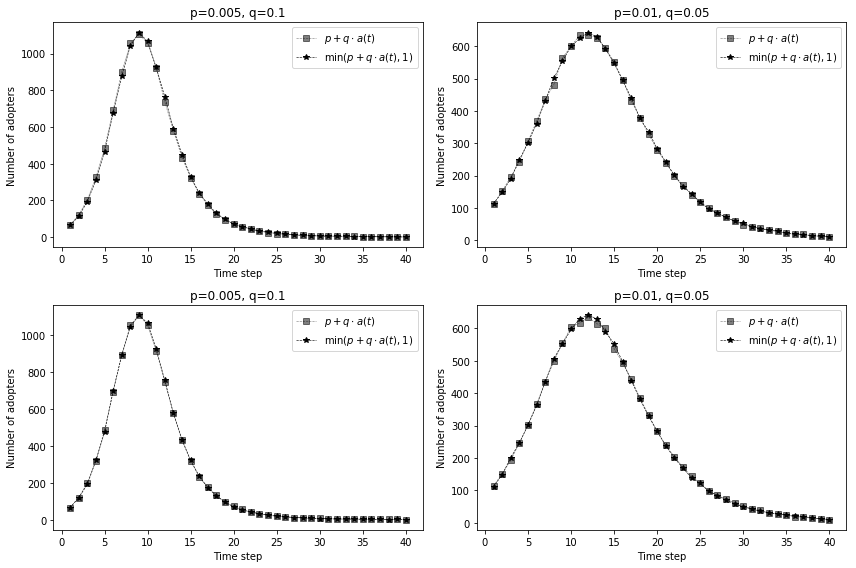

In [34]:
fig = plt.figure(figsize=(12,8))
for i, d in enumerate(pq_cont):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.set_title('p=%s, q=%s' % (d[0], d[1]))
    ax.plot(np.arange(1, 41), d_cont[i][0],  'ks--', alpha=0.5, lw=0.6, label ='$p+q\cdot a(t)$')
    ax.plot(np.arange(1, 41), d_cont[i][1],  'k*--', lw=0.6, label = '$\mathrm{min} (p+q\cdot a(t), 1)$')
    ax.set_xlabel('Time step')
    ax.set_ylabel('Number of adopters')
    ax.legend(loc='best')
    
fig.tight_layout()

## 2. $p + q \cdot a(t)$ 近似等效于 $1 - (1 - p)\cdot (1 - q) ^ {a(t)} $

In [4]:
import statsmodels.formula.api as smf
import pandas as pd

In [47]:
path = 'C:/Users/XIAOYU/PycharmProjects/A fast method(2nd round revision)/'

In [48]:
d1 = np.load(path + 'estimate gnm_random_graph(10000,30000)-lm.npy')
d2 = np.load(path + 'estimate gnm_random_graph(10000,30000)-gmm.npy')

In [49]:
p_d1 = pd.DataFrame(d1, columns=['p', 'q', 'P', 'Q', 'M', 'R2'])
p_d2 = pd.DataFrame(d2, columns=['p', 'q', 'P', 'Q', 'M', 'R2'])

In [50]:
p_d1.describe()

,p,q,P,Q,M,R2
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.011000,0.097500,0.005952,0.449534,9743.906492,0.986036
std,0.007107,0.028977,0.003375,0.118377,101.794311,0.008991
min,0.001000,0.050000,0.000777,0.245314,9150.858649,0.947470
25%,0.006000,0.073750,0.003554,0.346134,9753.575546,0.983445
50%,0.011000,0.097500,0.006421,0.453105,9775.218648,0.987632
75%,0.016000,0.121250,0.008398,0.549888,9782.757580,0.991878
max,0.021000,0.145000,0.012848,0.660923,9802.606045,0.999445


In [51]:
p_d2.describe()

,p,q,P,Q,M,R2
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.011000,0.097500,0.007040,0.406513,9698.970633,0.978660
std,0.007107,0.028977,0.003706,0.096987,125.541163,0.011172
min,0.001000,0.050000,0.000868,0.234997,8985.409201,0.937829
25%,0.006000,0.073750,0.004806,0.323382,9706.146719,0.973569
50%,0.011000,0.097500,0.007591,0.408905,9735.452853,0.980127
75%,0.016000,0.121250,0.010072,0.489286,9750.277068,0.985317
max,0.021000,0.145000,0.013235,0.577820,9793.382391,0.998800


In [52]:
results1 = smf.ols('p ~ P-1', data=p_d1).fit()
a = results1.params['P']
r2 = results1.rsquared
print a, r2

1.88498067712 0.970530497557


In [53]:
results1 = smf.ols('p ~ P-1', data=p_d2).fit()
a = results1.params['P']
r2 = results1.rsquared
print a, r2

1.62980368112 0.981023138213


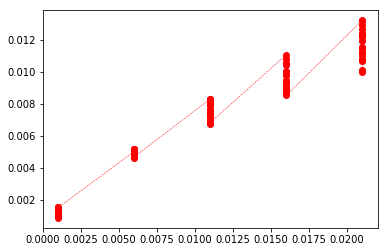

In [46]:
plt.plot(p_d2['p'], p_d2['P'], 'ro--', lw =0.5)